In [1]:
#!pip install torch


# MAF Implementation with Joint Distribution

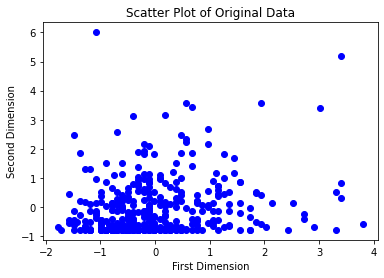

Number of Trainable Parameters in the MAF model: 109824.0
Epoch 0, Total Loss: 227.1953582763672, MAF Loss: 226.47264099121094, Classification Loss: 0.7227098345756531, Density Estimation Avg: -170.51976013183594
Epoch 10, Total Loss: -3747.603271484375, MAF Loss: -3748.27734375, Classification Loss: 0.6741774082183838, Density Estimation Avg: -4196.5556640625
Epoch 20, Total Loss: -8703.255859375, MAF Loss: -8703.900390625, Classification Loss: 0.6446677446365356, Density Estimation Avg: -9238.0390625
Epoch 30, Total Loss: -14065.689453125, MAF Loss: -14066.3173828125, Classification Loss: 0.6279890537261963, Density Estimation Avg: -14591.9794921875
Epoch 40, Total Loss: -19101.5234375, MAF Loss: -19102.12109375, Classification Loss: 0.5970972180366516, Density Estimation Avg: -19574.65234375
Training Time: 27.06999182701111 seconds
Variable: maf_model.flows.0.masked_autoregressive_nn.0.weight, Length: 128, Size: torch.Size([128, 10])
Variable: maf_model.flows.0.masked_autoregressive

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import seaborn as sns

import torch
import torch.nn as nn

# Import the required libraries for joint distribution plotting
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# MAF Loss Function
class MAFLoss(nn.Module):
    def __init__(self, model):
        super(MAFLoss, self).__init__()
        self.model = model

    def forward(self, x):
        z, log_det = self.model.maf_model(x)
        loss = -torch.mean(log_det)
        return loss

# Load Data
df = pd.read_csv("C:/Users/sharm/Downloads/SAHeart.csv")
features = ["sbp", "tobacco", "ldl", "adiposity", "famhist", "typea", "obesity", "alcohol", "age"]
X = df[features]
y = df["chd"]

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [i for i in range(len(features)) if X.iloc[:, i].dtype != 'O']),
        ('cat', categorical_transformer, [i for i in range(len(features)) if X.iloc[:, i].dtype == 'O'])
    ])

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = torch.tensor(X_preprocessed, dtype=torch.float32)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Enable Anomaly Detection
torch.autograd.set_detect_anomaly(True)

# MAF Model Definition
class MAF(nn.Module):
    def __init__(self, in_features, hidden_size, num_blocks):
        super(MAF, self).__init__()
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.num_blocks = num_blocks
        self.masks = self._create_masks()
        self.flows = nn.ModuleList([MAFBlock(in_features, hidden_size) for _ in range(num_blocks)])

    def forward(self, x):
        log_det = torch.zeros(x.size(0), device=x.device)
        for i in range(self.num_blocks):
            x, ld = self.flows[i](x, self.masks[i])
            log_det += ld
        return x, log_det

    def _create_masks(self):
        masks = []
        for _ in range(self.num_blocks):
            mask = torch.ones(self.in_features)
            mask[:self.in_features // 2] = 0
            masks.append(mask)
        return masks

class MAFBlock(nn.Module):
    def __init__(self, in_features, hidden_size):
        super(MAFBlock, self).__init__()
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.masked_autoregressive_nn = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, in_features)
        )

    def forward(self, x, mask):
        h = self.masked_autoregressive_nn(x * mask)
        z = x + (1 - mask) * h
        log_det = torch.sum((1 - mask) * torch.log(1e-8 + torch.abs(1 + h)))
        return z, log_det

# MAF Classification Model
class MAFClassificationModel(nn.Module):
    def __init__(self, in_features, hidden_size, num_blocks, num_classes):
        super(MAFClassificationModel, self).__init__()
        self.maf_model = MAF(in_features, hidden_size, num_blocks)
        self.classification_head = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        z, _ = self.maf_model(x)
        logits = self.classification_head(z)
        return logits

# Model Initialization
in_features = X_preprocessed.shape[1]
hidden_size = 128
num_blocks = 6
num_classes = 2

model = MAFClassificationModel(in_features, hidden_size, num_blocks, num_classes)

# Loss Function for Classification
classification_criterion = nn.CrossEntropyLoss()
maf_criterion = MAFLoss(model)

# Training Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

# Data Generation
def sample_2(num_samples=1500):
    second_dimension = np.random.normal(0, 1, num_samples)
    first_dimension = second_dimension ** 2
    return np.column_stack((first_dimension, second_dimension))

# Create a list to store the generated samples during training
generated_samples = []

# Visualize scatter plot
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label='Original Data')
plt.title("Scatter Plot of Original Data")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")
plt.show()

# Print Number of Trainable Parameters
D = X_preprocessed.shape[1]  # Number of Features
L = 3  # Number of hidden layers in each AR block
K = 6  # Number of AR blocks (MADE)
H = 128  # Hidden units for each AR block

num_parameters = (3/2)*K*D*H + 1/2*K*(L-1)*H**2
print(f"Number of Trainable Parameters in the MAF model: {num_parameters}")

# Print Training Time and Variable Sizes
start_time = time.time()

global_step = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train)

    # Convert y_train to PyTorch tensor
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

    classification_loss = classification_criterion(logits, y_train_tensor)
    maf_loss = maf_criterion(X_train)

    total_loss = maf_loss + classification_loss

    # Calculate mean loss over the batch
    total_loss_mean = total_loss.mean()

    total_loss_mean.backward()
    optimizer.step()

    # Generate samples from the learned joint distribution
    with torch.no_grad():
        model.eval()
        samples, _ = model.maf_model(torch.randn_like(X_train))
        generated_samples.append(samples.cpu().numpy())

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Calculate density estimation average
            _, log_det = model.maf_model(X_train)
            density_estimation_avg = -log_det.mean().item()

            print(f"Epoch {epoch}, Total Loss: {total_loss_mean.item()}, MAF Loss: {maf_loss.item()}, Classification Loss: {classification_loss.item()}, Density Estimation Avg: {density_estimation_avg}")

    global_step.append(epoch)
    train_losses.append(total_loss_mean.item())

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")


# Print the length and sizes of trainable variables
for name, param in model.named_parameters():
    print(f"Variable: {name}, Length: {len(param)}, Size: {param.size()}")

# Evaluation
torch.autograd.set_detect_anomaly(False)
model.eval()
with torch.no_grad():
    logits = model(X_test)
    predicted_labels = torch.argmax(logits, dim=1)

    # Calculate density estimation average on the test set
    _, log_det_test = model.maf_model(X_test)
    density_estimation_avg_test = -log_det_test.mean().item()

# Print Results
accuracy = accuracy_score(y_test, predicted_labels.numpy())
f1 = f1_score(y_test, predicted_labels.numpy())
print(f"Final Accuracy: {accuracy}, Final F1 Score: {f1}, Final Density Estimation Avg (Test): {density_estimation_avg_test}")


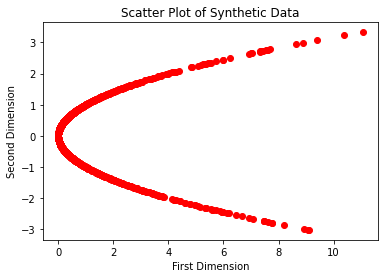

In [2]:
# Data Generation
def sample_2(num_samples=1500):
    second_dimension = np.random.normal(0, 1, num_samples)
    first_dimension = second_dimension ** 2
    return np.column_stack((first_dimension, second_dimension))

# Generate synthetic dataset with the same number of features as X_train
synthetic_data = sample_2()

# Visualize scatter plot
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red')
plt.title("Scatter Plot of Synthetic Data")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")
plt.show()


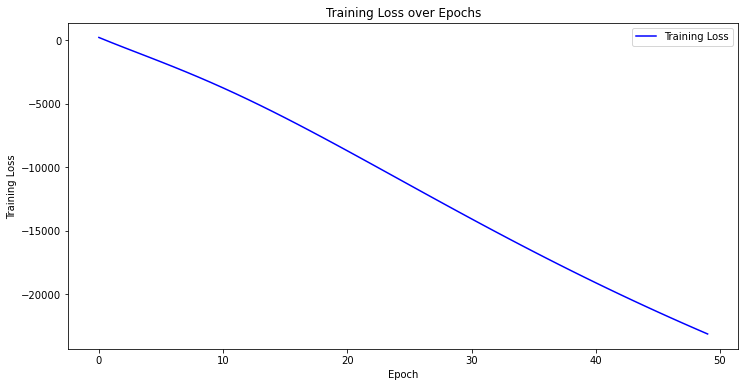

In [3]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(global_step, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()



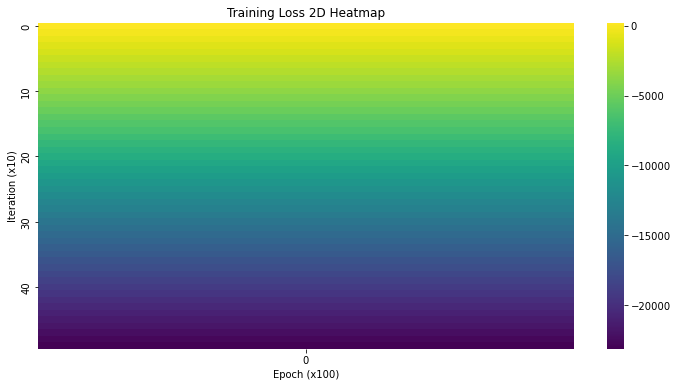

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plot 2D Heatmap for Training Loss
plt.figure(figsize=(12, 6))
sns.heatmap(np.array(train_losses).reshape(-1, 1), cmap='viridis', cbar=True, xticklabels=100, yticklabels=10)
plt.title('Training Loss 2D Heatmap')
plt.xlabel('Epoch (x100)')
plt.ylabel('Iteration (x10)')
plt.show()


Epoch 0, Total Loss: -23550.56640625, MAF Loss: -23551.15234375, Classification Loss: 0.5860504508018494, Density Estimation Avg: -23962.720703125
Epoch 10, Total Loss: -27415.2265625, MAF Loss: -27415.802734375, Classification Loss: 0.57622891664505, Density Estimation Avg: -27773.544921875
Epoch 20, Total Loss: -30786.638671875, MAF Loss: -30787.224609375, Classification Loss: 0.5868061184883118, Density Estimation Avg: -31100.82421875
Epoch 30, Total Loss: -33755.79296875, MAF Loss: -33756.375, Classification Loss: 0.5839832425117493, Density Estimation Avg: -34034.32421875
Epoch 40, Total Loss: -36401.15234375, MAF Loss: -36401.74609375, Classification Loss: 0.5946813225746155, Density Estimation Avg: -36650.96484375
Average Total Loss: -31783.8715625, Average MAF Loss: -31784.4555078125, Average Classification Loss: 0.584023324251175


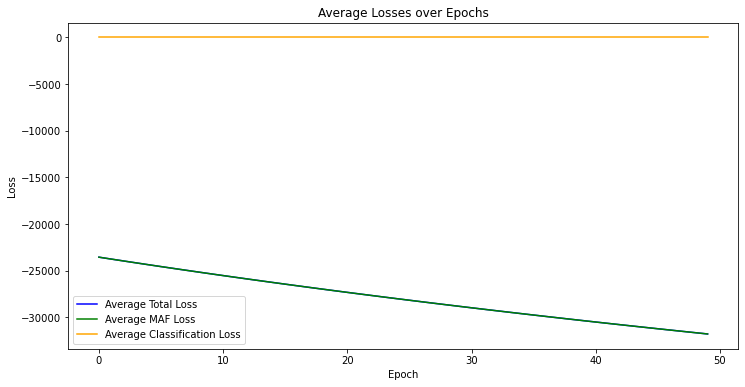

In [5]:
# Initialize variables to store total and average losses
total_loss_sum = 0.0
maf_loss_sum = 0.0
classification_loss_sum = 0.0

total_loss_avg = []
maf_loss_avg = []
classification_loss_avg = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train)

    # Convert y_train to PyTorch tensor
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

    classification_loss = classification_criterion(logits, y_train_tensor)
    maf_loss = maf_criterion(X_train)

    total_loss = maf_loss + classification_loss

    # Calculate mean loss over the batch
    total_loss_mean = total_loss.mean()

    total_loss_mean.backward()
    optimizer.step()

    # Update sum values
    total_loss_sum += total_loss_mean.item()
    maf_loss_sum += maf_loss.item()
    classification_loss_sum += classification_loss.item()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Calculate density estimation average
            _, log_det = model.maf_model(X_train)
            density_estimation_avg = -log_det.mean().item()

            print(f"Epoch {epoch}, Total Loss: {total_loss_mean.item()}, MAF Loss: {maf_loss.item()}, Classification Loss: {classification_loss.item()}, Density Estimation Avg: {density_estimation_avg}")

    total_loss_avg.append(total_loss_sum / (epoch + 1))
    maf_loss_avg.append(maf_loss_sum / (epoch + 1))
    classification_loss_avg.append(classification_loss_sum / (epoch + 1))

# Print average values
print(f"Average Total Loss: {total_loss_avg[-1]}, Average MAF Loss: {maf_loss_avg[-1]}, Average Classification Loss: {classification_loss_avg[-1]}")

# Plot average losses over epochs
plt.figure(figsize=(12, 6))
plt.plot(global_step, total_loss_avg, label='Average Total Loss', color='blue')
plt.plot(global_step, maf_loss_avg, label='Average MAF Loss', color='green')
plt.plot(global_step, classification_loss_avg, label='Average Classification Loss', color='orange')
plt.title('Average Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


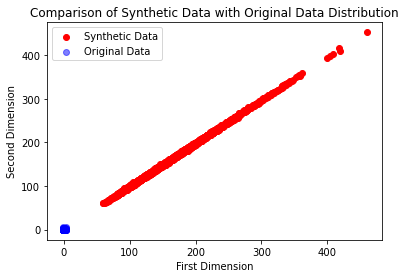

In [6]:
# Generate synthetic samples using the trained MAF model
num_synthetic_samples = 1500

with torch.no_grad():
    model.eval()
    
    # Sample from a standard normal distribution
    z = torch.randn(num_synthetic_samples, in_features)
    
    # Apply the inverse transformation using the MAF model
    synthetic_samples, _ = model.maf_model(z)

# Convert synthetic samples to numpy array
synthetic_samples = synthetic_samples.cpu().numpy()

# Visualize scatter plot of synthetic samples to compare with the original data distribution
plt.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], color='red', label='Synthetic Data')
plt.title("Comparison of Synthetic Data with Original Data Distribution")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")

# Plot original data for comparison
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', alpha=0.5, label='Original Data')

plt.legend()
plt.show()


# Joint Distribution Visualization Plots

C:\Users\sharm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sharm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'PCA of Generated Samples')

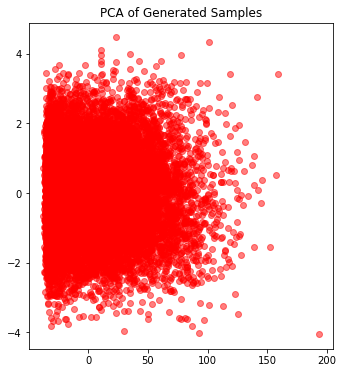

In [7]:
# Visualize the generated samples using PCA or t-SNE
generated_samples = np.concatenate(generated_samples, axis=0)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

pca_result = pca.fit_transform(generated_samples)
tsne_result = tsne.fit_transform(generated_samples)

# Plot PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='red', alpha=0.5)
plt.title('PCA of Generated Samples')



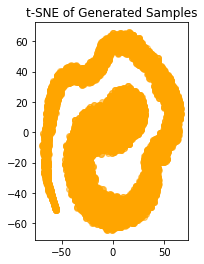

In [8]:
# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color='orange', alpha=0.5)
plt.title('t-SNE of Generated Samples')

plt.show()


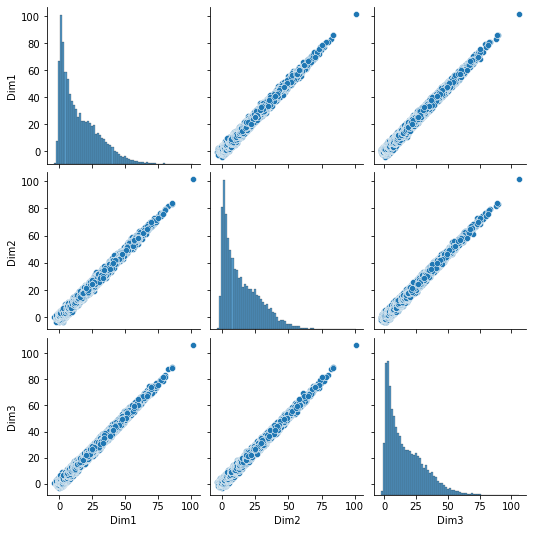

In [9]:
# Pair plot for the first three dimensions
sns.pairplot(pd.DataFrame(generated_samples[:, :3], columns=['Dim1', 'Dim2', 'Dim3']))
plt.show()


Assuming that the number of dimensions in generated_samples is greater than 6, we have the following plots:

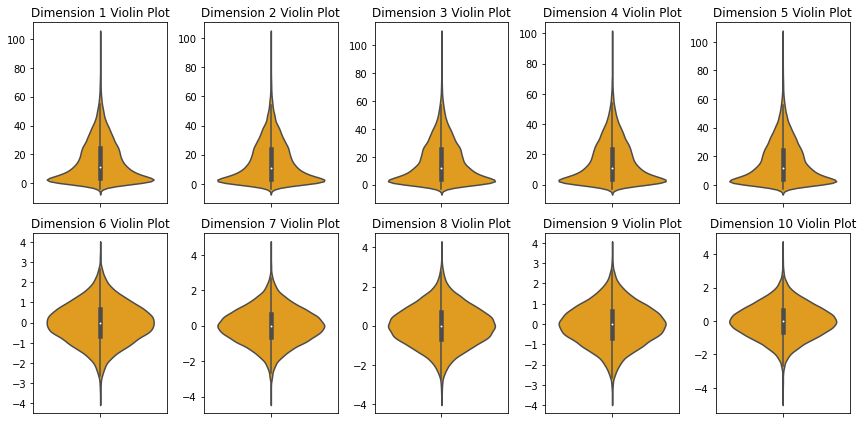

In [10]:
# Violin plots for each dimension
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    sns.violinplot(y=generated_samples[:, i], color='orange')
    plt.title(f'Dimension {i+1} Violin Plot')
plt.tight_layout()
plt.show()


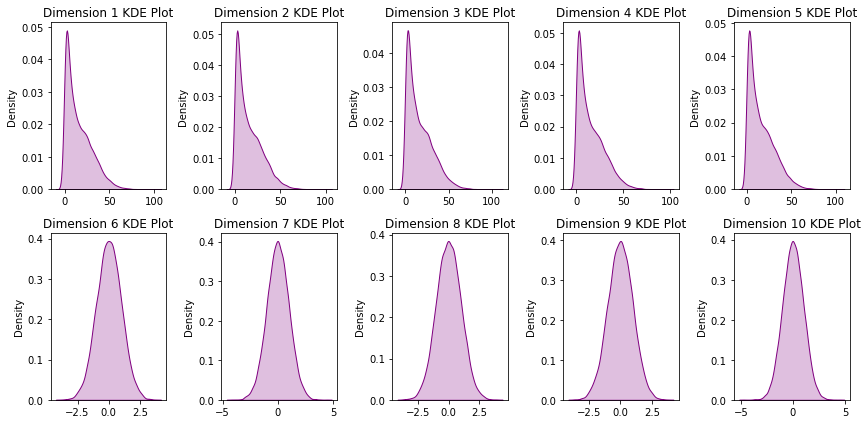

In [11]:
# KDE plots for each dimension
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(generated_samples[:, i], color='purple', fill=True)
    plt.title(f'Dimension {i+1} KDE Plot')
plt.tight_layout()
plt.show()


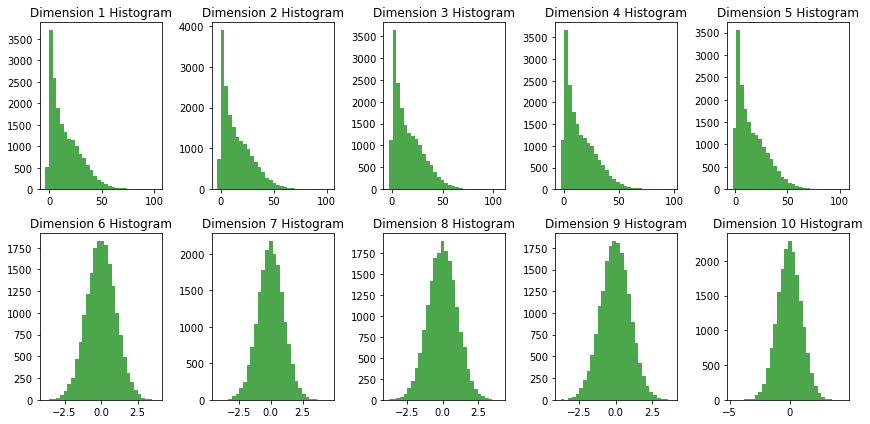

In [12]:
# Plot histograms for each dimension
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    plt.hist(generated_samples[:, i], bins=30, color='green', alpha=0.7)
    plt.title(f'Dimension {i+1} Histogram')
plt.tight_layout()
plt.show()


# Real NVP Implementation with Joint Distribution

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

# Define real_nvp_loss function
def real_nvp_loss(model, x):
    z, log_det_J = model.real_nvp_model(x)
    return -(model.real_nvp_model.base_distribution.log_prob(z) + log_det_J).mean()

# Load data
df = pd.read_csv("C:/Users/sharm/Downloads/SAHeart.csv")

# Specify features and target
features = ["sbp", "tobacco", "ldl", "adiposity", "famhist", "typea", "obesity", "alcohol", "age"]
X = df[features]
y = df["chd"]

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [i for i in range(len(features)) if X.iloc[:, i].dtype != 'O']),
        ('cat', categorical_transformer, [i for i in range(len(features)) if X.iloc[:, i].dtype == 'O'])
    ])

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = torch.tensor(X_preprocessed, dtype=torch.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Update CouplingLayer to include an inverse transformation
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.scale = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )
        self.translation = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.scale(x_a)
        t = self.translation(x_a)
        y_b = x_b * torch.exp(s) + t
        y_a = x_a
        return torch.cat([y_a, y_b], dim=1), torch.sum(s, dim=1)

    def inverse(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.scale(y_a)
        t = self.translation(y_a)
        x_b = (y_b - t) * torch.exp(-s)
        x_a = y_a
        return torch.cat([x_a, x_b], dim=1)

# Update RealNVPModel to make it invertible
class RealNVPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super(RealNVPModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_flows = num_flows

        self.transforms = nn.ModuleList([
            CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)
        ])

        self.base_distribution = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

    def forward(self, x):
        log_det_J = torch.zeros(x.shape[0], device=x.device)
        for transform in self.transforms:
            x, ldj = transform(x)
            log_det_J += ldj
        return x, log_det_J

    def inverse(self, z):
        for transform in reversed(self.transforms):
            z = transform.inverse(z)
        return z

# Extend RealNVPModel to include a classification head
class RealNVPClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows, num_classes):
        super(RealNVPClassificationModel, self).__init__()
        self.real_nvp_model = RealNVPModel(input_dim, hidden_dim, num_flows)
        self.classification_head = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        z, log_det_J = self.real_nvp_model(x)
        return self.classification_head(z)

# Create an instance of the RealNVPClassificationModel
input_dim = X_preprocessed.shape[1]  # Define input_dim
hidden_dim = 32  # Define hidden_dim
num_classes = 2  # Assuming binary classification based on your use of accuracy and f1_score
num_flows = 4  # Define num_flows
real_nvp_classification_model = RealNVPClassificationModel(input_dim, hidden_dim, num_flows, num_classes)

# Define classification loss (cross-entropy)
classification_loss = nn.CrossEntropyLoss()

# Train the model
optimizer = torch.optim.Adam(real_nvp_classification_model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []  # Track total losses
classification_losses = []  # Track classification losses
nvp_losses = []  # Track NVP losses

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch_loss

    optimizer.zero_grad()

    # Forward pass
    outputs = real_nvp_classification_model(X_train)

    # Convert y_train to tensor
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    
    # Compute classification loss
    loss_classification = classification_loss(outputs, y_train_tensor)

    # Compute real NVP loss
    loss_real_nvp = real_nvp_loss(real_nvp_classification_model, X_train)

    # Total loss is a combination of classification and real NVP loss
    total_loss = loss_classification + loss_real_nvp

    # Backward pass
    total_loss.backward()

    # Update weights
    optimizer.step()

    # Store the training losses for later visualization
    train_losses.append(total_loss.item())
    classification_losses.append(loss_classification.item())
    nvp_losses.append(loss_real_nvp.item())  # Track NVP losses


# Disable anomaly detection after training
torch.autograd.set_detect_anomaly(False)



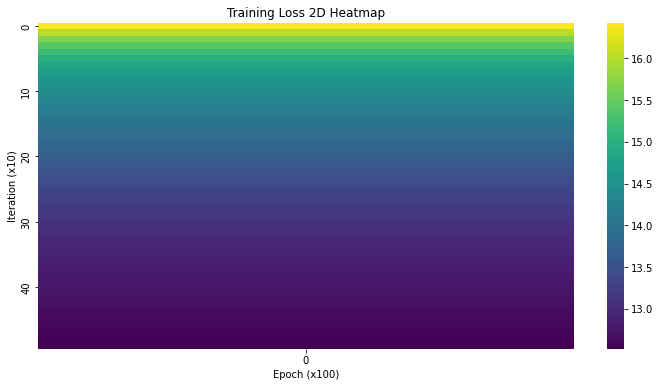

In [14]:
# Plot 2D Heatmap for Training Loss
plt.figure(figsize=(12, 6))
sns.heatmap(np.array(train_losses).reshape(-1, 1), cmap='viridis', cbar=True, xticklabels=100, yticklabels=10)
plt.title('Training Loss 2D Heatmap')
plt.xlabel('Epoch (x100)')
plt.ylabel('Iteration (x10)')
plt.show()



In [15]:
# Evaluate the Real NVP classification model
with torch.no_grad():
    # Forward pass on test data
    outputs_test = real_nvp_classification_model(X_test)

    # Get predicted labels
    _, predicted_labels = torch.max(outputs_test, 1)

    # Convert y_test to tensor
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_tensor, predicted_labels.numpy())
    f1 = f1_score(y_test_tensor, predicted_labels.numpy())

    print("Real NVP Classification Accuracy:", accuracy)
    print("Real NVP Classification F1:", f1)
    


Real NVP Classification Accuracy: 0.5806451612903226
Real NVP Classification F1: 0.606060606060606


In [16]:
# Print the results
print("NVP Loss:", loss_real_nvp.item())
print("Total Loss:", total_loss.item())
print("Classification Loss:", loss_classification.item())



NVP Loss: 11.8359375
Total Loss: 12.51959228515625
Classification Loss: 0.68365478515625


In [17]:
# Calculate average density estimation
num_samples = 1000  # You can adjust this based on your needs
with torch.no_grad():
    sample_inputs = torch.randn(num_samples, input_dim)
    sample_z, _ = real_nvp_classification_model.real_nvp_model(sample_inputs)
    avg_density_estimation = torch.exp(
        -real_nvp_classification_model.real_nvp_model.base_distribution.log_prob(sample_z).mean()
    )

print("Average Density Estimation:", avg_density_estimation.item())


Average Density Estimation: 1046581568.0


In [18]:
# Print the length and sizes of trainable variables
for name, param in real_nvp_classification_model.named_parameters():
    print(f"Parameter: {name}, Size: {param.size()}")


Parameter: real_nvp_model.transforms.0.scale.0.weight, Size: torch.Size([32, 5])
Parameter: real_nvp_model.transforms.0.scale.0.bias, Size: torch.Size([32])
Parameter: real_nvp_model.transforms.0.scale.2.weight, Size: torch.Size([5, 32])
Parameter: real_nvp_model.transforms.0.scale.2.bias, Size: torch.Size([5])
Parameter: real_nvp_model.transforms.0.translation.0.weight, Size: torch.Size([32, 5])
Parameter: real_nvp_model.transforms.0.translation.0.bias, Size: torch.Size([32])
Parameter: real_nvp_model.transforms.0.translation.2.weight, Size: torch.Size([5, 32])
Parameter: real_nvp_model.transforms.0.translation.2.bias, Size: torch.Size([5])
Parameter: real_nvp_model.transforms.1.scale.0.weight, Size: torch.Size([32, 5])
Parameter: real_nvp_model.transforms.1.scale.0.bias, Size: torch.Size([32])
Parameter: real_nvp_model.transforms.1.scale.2.weight, Size: torch.Size([5, 32])
Parameter: real_nvp_model.transforms.1.scale.2.bias, Size: torch.Size([5])
Parameter: real_nvp_model.transforms.

In [19]:
# Print Number of Trainable Parameters
total_params = sum(p.numel() for p in real_nvp_classification_model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")



Total Trainable Parameters: 2878


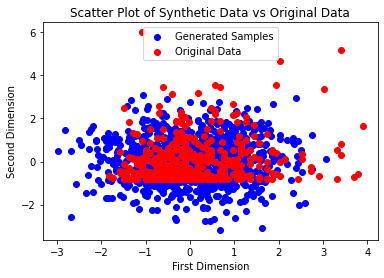

In [20]:
# After training, you can sample from the learned distribution
# Generate synthetic samples
num_samples = 1000
with torch.no_grad():
    # Sample from the learned distribution
    sample_z = torch.randn(num_samples, input_dim)
    sample_x = real_nvp_classification_model.real_nvp_model.inverse(sample_z)

# Visualize scatter plot for Synthetic Data
plt.scatter(sample_x[:, 0], sample_x[:, 1], color='blue', label='Generated Samples')

# Generate synthetic data for comparison
with torch.no_grad():
    # Sample from the original distribution (prior distribution)
    synthetic_z = torch.randn(num_samples, input_dim)
    synthetic_data = real_nvp_classification_model.real_nvp_model.inverse(synthetic_z)

# Assuming X_preprocessed is your original data
plt.scatter(X_preprocessed[:, 0], X_preprocessed[:, 1], color='red', label='Original Data')
plt.title("Scatter Plot of Synthetic Data vs Original Data")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")
plt.legend()
plt.show()


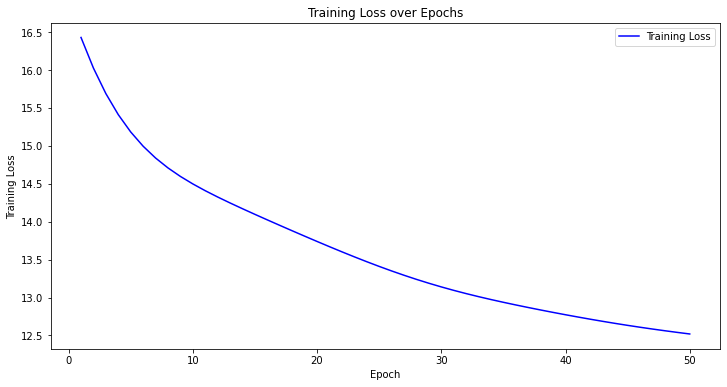

In [21]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


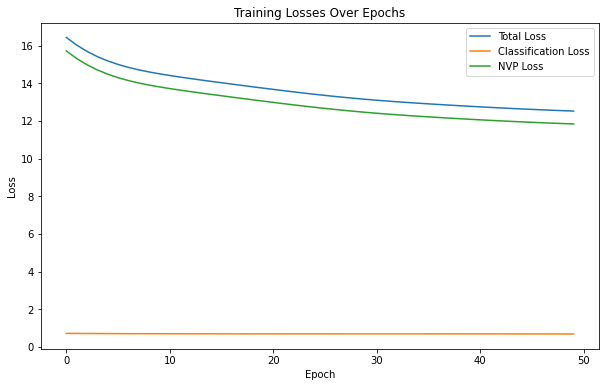

In [22]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Total Loss')
plt.plot(classification_losses, label='Classification Loss')
plt.plot(nvp_losses, label='NVP Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.show()


# Joint Distribution Visualization

C:\Users\sharm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sharm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


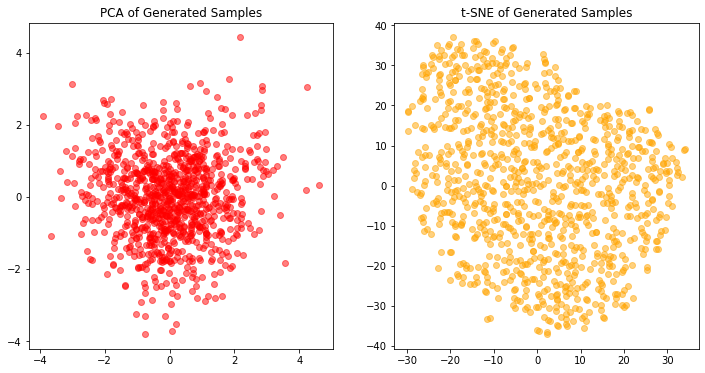

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming num_samples is the number of synthetic samples you want to generate
num_samples = 1000

# Generate synthetic samples using the trained RealNVP model
with torch.no_grad():
    sample_z = torch.randn(num_samples, input_dim)
    generated_samples_tensor = real_nvp_classification_model.real_nvp_model.inverse(sample_z)

# Convert the generated samples to a numpy array
generated_samples = generated_samples_tensor.numpy()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(generated_samples)

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(generated_samples)

# Plot PCA and t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='red', alpha=0.5)
plt.title('PCA of Generated Samples')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color='orange', alpha=0.5)
plt.title('t-SNE of Generated Samples')

plt.show()


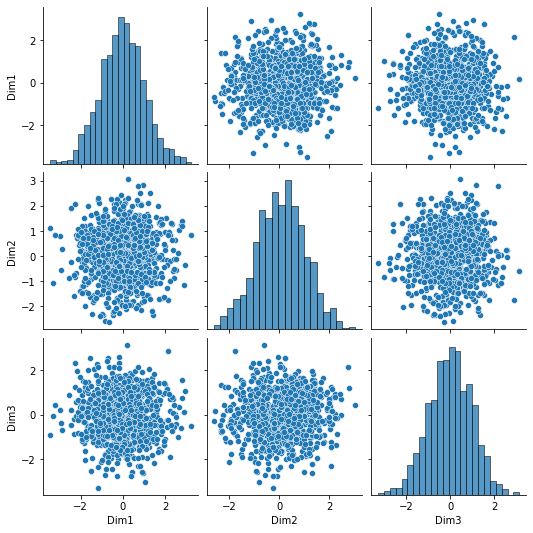

In [24]:
# Assuming generated_samples is a numpy array containing the generated samples
df_generated_samples = pd.DataFrame(generated_samples[:, :3], columns=['Dim1', 'Dim2', 'Dim3'])

# Pair plot
sns.pairplot(df_generated_samples)
plt.show()


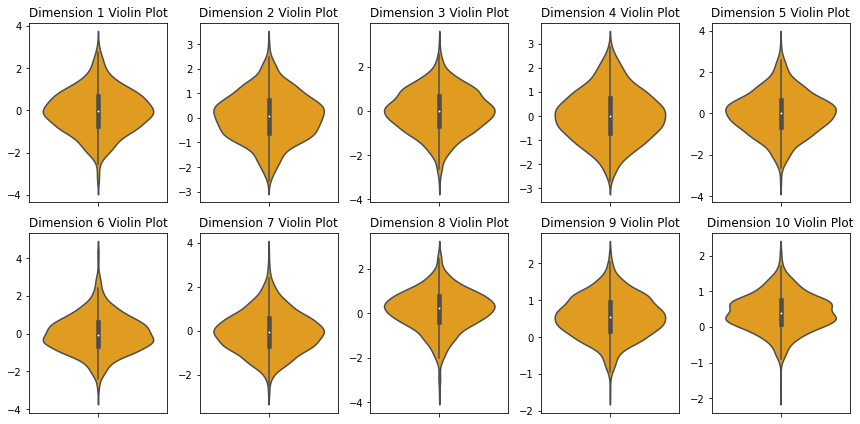

In [25]:
# Assuming generated_samples is a numpy array containing the generated samples
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    sns.violinplot(y=generated_samples[:, i], color='orange')
    plt.title(f'Dimension {i+1} Violin Plot')
plt.tight_layout()
plt.show()


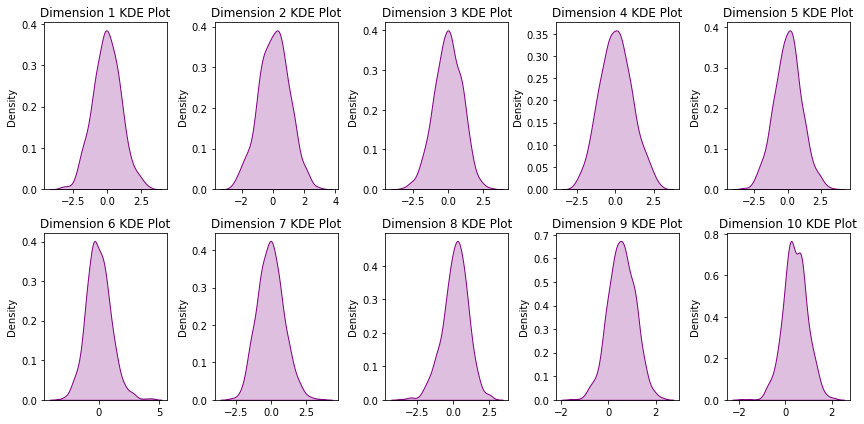

In [26]:
# Assuming generated_samples is a numpy array containing the generated samples
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(generated_samples[:, i], color='purple', fill=True)
    plt.title(f'Dimension {i+1} KDE Plot')
plt.tight_layout()
plt.show()


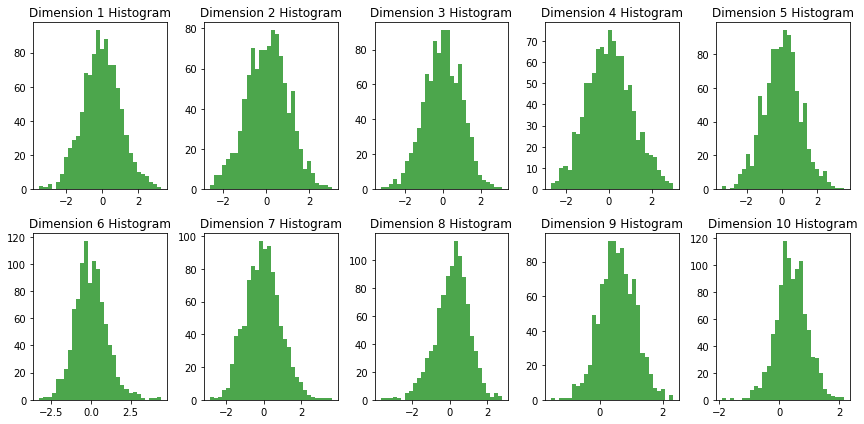

In [27]:
# Assuming generated_samples is a numpy array containing the generated samples
num_dimensions = generated_samples.shape[1]
rows = 2
cols = (num_dimensions + 1) // 2  # Ensure at least two columns

plt.figure(figsize=(12, 6))
for i in range(num_dimensions):
    plt.subplot(rows, cols, i + 1)
    plt.hist(generated_samples[:, i], bins=30, color='green', alpha=0.7)
    plt.title(f'Dimension {i+1} Histogram')
plt.tight_layout()
plt.show()
